In [1]:
# coding=utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
from logging_future import logger

In [2]:
location = "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/数据库/火币日线/11_19_prepared_data_for_ML/" 

file1 = "res_11_14_huobi_ada乘10000.csv"
file2 = "res_11_14_huobi_bch乘1.csv"
file3 = "res_11_14_huobi_btcusdt.csv"
file4 = "res_11_14_huobi_eos乘100.csv"
file5 = "res_11_14_huobi_eth乘1.csv"
file6 = "res_11_14_huobi_ltc乘10.csv"
file7 = "res_11_14_huobi_trx乘10000.csv"
file8 = "res_11_14_huobi_xrp乘1000.csv"

df_ada = pd.read_csv(location + file1, engine="python")
df_bch = pd.read_csv(location + file2, engine="python")
df_btc = pd.read_csv(location + file3, engine="python")
df_eos = pd.read_csv(location + file4, engine="python")
df_eth = pd.read_csv(location + file5, engine="python")
df_ltc = pd.read_csv(location + file6, engine="python")
df_trx = pd.read_csv(location + file7, engine="python")
df_xrp = pd.read_csv(location + file8, engine="python")

In [139]:
def lstm_run_through_all(df, asst, test_train_split, time_step, rnn_unit, batch_size, train_times, lr):
    # Use this code to prevent the kernel from requesting to start again everytime we run the model. 
    tf.reset_default_graph()
    
    data_len = len(df)
    total_days = data_len
    test_end = total_days
    train_begin = 0
    
    pre_data = df.iloc[:, 4].values  # 取收盘价计算标签
    label = []
    for i in range(1, len(pre_data)):
        label.append(round(pre_data[i] - pre_data[i - 1], 4))

    df.loc[1:, 'label'] = label
    df['label'] = df['label'].shift(-1)
    df.fillna(method='ffill', inplace = True)
    data = df.iloc[:, [1, 2, 3, 5]].values  # 获取特征量及标签，类型为np.ndarray
    # logger.info(data[0:5])

    
    # 参数类别一：
    """
    保持以下参数不变：

    利用过去一天: 2018-11-16 0:00, 来预测下一天：
    time_step = 20
    rnn_unit = 10  # 隐藏层单元数量 ##################调整这个
    input_size = 3  # 输入个数  
    output_size = 1  # 输出个数
    batch_size = 80  # 批量大小  #################调整这个
    train_times = 20  # 训练次数
    lr = 0.001  # 学习率


    test_train_split 参数调优:

    test_train_split   accuracy       信号强度
           0.2           0.55         -55.86
           0.3           0.52         -39.31
           0.4           0.4928        -9.88
           0.5           0.5111       -28.13
           0.6           0.5          -13.87
           0.7           0.4961       -27.13
           0.8           0.4967       -28.58
           0.9           0.5          -9.06

    """

    test_train_split = test_train_split
    time_step = time_step # 20 as default
    split_batch = int(total_days/time_step) 
    time_step_multiple = int(test_train_split*split_batch)
    test_begin = int(test_end - (time_step)*time_step_multiple)
    train_end = test_begin

    # 这里 test_end - test_begin的差一定要是time_step的倍数
#     print ("split_batch: ", split_batch)
#     print ("train_test_split_rate: ", test_train_split)
#     print ("train_begin: ", train_begin)
#     print ("train_end: ", train_end)
#     print ("test_begin: ", test_begin)
#     print ("test_end: ", test_end)
#     print ("time_step: ", time_step)

    # 参数类别二：

    rnn_unit = rnn_unit # 1o as default  # 隐藏层单元数量 ##################调整这个
    input_size = 3  # 输入个数  
    output_size = 1  # 输出个数
    batch_size = batch_size # 80 as default  # 批量大小  #################调整这个
    train_times = train_times # 20 as default  # 训练次数
    lr = lr # 0.001 as default  # 学习率
    # 一般调整隐藏层数量、批量大小及学习率这几个超参数
    # 输入和输出则由特征量和标签确定
    # 本例中，以开盘价、最高价、最低价为特征量，
    # 以收盘价差即涨跌作为标签
    
    
    
    print ("="*60)
    def get_train_data(batch_size, time_step, train_begin, train_end):
        batch_index = []
        data_train = data[train_begin + 1:train_end]
        normalized_train_data = (
            data_train - np.mean(data_train, axis=0)) / np.std(
                data_train, axis=0)
        # logger.info('normalized_train_data.shape: ', normalized_train_data.shape)
        # logger.info(len(normalized_train_data))
        # logger.info(type(normalized_train_data))
        # logger.info(len([0, 2]))
        # logger.info(normalized_train_data[0:20])
        # logger.info(normalized_train_data[0:20, 1])

        train_x, train_y = [], []
        for i in range(len(normalized_train_data) - time_step):
            if i % batch_size == 0:
                batch_index.append(i)

            x = normalized_train_data[i:i + time_step, :3]
            y = normalized_train_data[i:i + time_step, 3, np.newaxis]
            train_x.append(x.tolist())
            train_y.append(y.tolist())

        batch_index.append(len(normalized_train_data) - time_step)
        return batch_index, train_x, train_y


    def get_test_data(time_step, test_begin, test_end):
        data_test = data[test_begin:test_end]
        test_y = data_test[:, 3]
        mean = np.mean(data_test, axis=0)
        std = np.std(data_test, axis=0)
        normalized_test_data = (data_test - mean) / std
        size = (len(normalized_test_data) + time_step - 1) // time_step
        test_x, test_y = [], []
        for i in range(size - 1):
            x = normalized_test_data[i * time_step:(i + 1) * time_step, :3]
            y = normalized_test_data[i * time_step:(i + 1) * time_step, 3]
            test_x.append(x.tolist())
            test_y.extend(y)
            # print('type(y): ', type(y))

        test_x.append((normalized_test_data[(i + 1) * time_step:, :3]).tolist())
        test_y.extend((normalized_test_data[(i + 1) * time_step:, 3]).tolist())
        return mean, std, test_x, test_y


    weights = {
        'in': tf.Variable(tf.random_normal([input_size, rnn_unit])),
        'out': tf.Variable(tf.random_normal([rnn_unit, 1]))
    }
    biases = {
        'in': tf.Variable(tf.constant(0.1, shape=[
            rnn_unit,
        ])),
        'out': tf.Variable(tf.constant(0.1, shape=[
            1,
        ]))
    }


    # 定义神经网络变量
    def lstm(X):
        batch_size = tf.shape(X)[0]
        time_step = tf.shape(X)[1]
        w_in = weights['in']
        b_in = biases['in']
        input_ = tf.reshape(X, [-1, input_size])
        # print('input_.shape: ', input_.shape)
        input_rnn = tf.matmul(input_, w_in) + b_in
        # print('input_rnn.shape: ', input_rnn.shape)
        # tensor转换成3维，作为cell的输入
        input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])
        # print('input_rnn.shape: ', input_rnn.shape)
        cell = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
        init_state = cell.zero_state(batch_size, dtype=tf.float32)
        output_rnn, final_state = tf.nn.dynamic_rnn(
            cell, input_rnn, initial_state=init_state, dtype=tf.float32)
        output = tf.reshape(output_rnn, [-1, rnn_unit])
        w_out = weights['out']
        b_out = biases['out']
        pred = tf.matmul(output, w_out) + b_out
        return pred, final_state


    # 训练模型
    def train_lstm(batch_size, time_step, train_begin, train_end):
        X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
        Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])
        batch_index, train_x, train_y = get_train_data(batch_size, time_step,
                                                       train_begin, train_end)
        with tf.variable_scope('future_lstm'):
            pred, _ = lstm(X)
            loss = tf.reduce_mean(
                tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
            train_operation = tf.train.AdamOptimizer(lr).minimize(loss)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)

            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                for i in range(train_times):
                    for step in range(len(batch_index) - 1):
                        _, loss_ = sess.run(
                            [train_operation, loss],
                            feed_dict={
                                X:
                                train_x[batch_index[step]:batch_index[step + 1]],
                                Y: train_y[batch_index[step]:batch_index[step + 1]]
                            })
                    # print('Number of iterations: {} , loss: {}'.format(i, loss_))
#                     logger.info('Number of iterations: {} , loss: {}'.format(
#                         i, loss_))
    #             print('model saved: ', saver.save(sess, 'model_save1/model.ckpt'))
                print('The train has finished')


    train_lstm(batch_size, time_step, train_begin, train_end)


    def prediction(time_step):
        X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
    #     print ("X: ", X)  #brad's peek
        mean, std, test_x, test_y = get_test_data(time_step, test_begin, test_end)
        with tf.variable_scope('future_lstm', reuse=True):
            pred, _ = lstm(X)
            saver = tf.train.Saver(tf.global_variables())
            with tf.Session() as sess:
                model_file = tf.train.latest_checkpoint('model_save1')
                saver.restore(sess, model_file)
                test_predict = []
                # brad's peek:
    #             print("test_x")
    #             print (test_x)
                for step in range(len(test_x)):
                    # 一次出time_step个结果，results.shape: (20, 1)
                    results = sess.run(pred, feed_dict={X: [test_x[step]]})
                    # predict = tf.reshape(results, [-1])
                    predict = results.reshape(-1)
                    test_predict.extend(predict)
                # brad's peek:
    #             print (test_predict)
                # 还原真实值
                # brad's peek:
    #             print ("test_y",test_y)
                test_y = np.array(test_y) * std[3] + mean[3]
                test_predict = np.array(test_predict) * std[3] + mean[3]
                true_y = test_y


                # print('test_predict.shape: ', test_predict.shape)
                # print('true_y.shape: ', true_y.shape)
                out = np.c_[test_predict, true_y]
                out_csv = pd.DataFrame(
                    data=out, index=None, columns=['prediction', 'true'])
                out_csv.to_csv(location + 'pred_and_true_20181119_{}.csv'.format(asst))
                # 计算精度
                right, wrong = 0, 0
                calc_data = map(lambda x, y: tuple((x, y)), test_predict,
                                test_y[:len(test_predict)])
                for data in calc_data:
                    if data[0] * data[1] > 0 or data[0] == data[1]:
                        right += 1
                    else:
                        wrong += 1
                accuracy = right / (right + wrong)
                print("利用过去一天: "+str(df[:test_end].iloc[-1, :].values[0]) + ", 来预测下一天：")
                print (out_csv.iloc[-1, 0])
                logger.info('The accuracy of this prediction: ')
                logger.info(accuracy)
                # print('The accuracy of this prediction: ', accuracy)
                # 计算偏差程度
                # deviation = np.average(
                #     np.abs(test_predict - test_y[:len(test_predict)]) /
                #     test_y[:len(test_predict)])
                # print('The deviation of this prediction: ', deviation)
                # logger.info('The deviation of this prediction: ')
                # logger.info(deviation)
                # logger.info(np.abs(test_predict - test_y[:len(test_predict)]))
                # logger.info(test_y[:len(test_predict)])

    #             fig = plt.figure()
    #             fig.set_size_inches(64, 48)
    #             ax = plt.gca()
    #             ax.spines['left'].set_linewidth(3)
    #             ax.spines['bottom'].set_linewidth(3)
    #             # 设置刻度大小
    #             rc('xtick', labelsize=40)
    #             rc('ytick', labelsize=40)
    #             plt.plot(
    #                 list(range(len(test_predict))),
    #                 test_predict,
    #                 color='blue',
    #                 label='predict',
    #             )
    #             plt.plot(
    #                 list(range(len(test_y))), test_y, color='red', label='real')
    #             # 设置图例及X、Y轴标签，label名称支持Tex语法
    #             plt.legend(loc='best', fontsize=60)
    #             plt.xlabel(r'$\rm{dailydata}$', fontdict={'size': 60})
    #             plt.ylabel(r'$\rm{fluctuation}$', fontdict={'size': 60})
    #             plt.savefig(
    #                 'future_lstm_train{}_accuracy{:.4f}.png'.format(
    #                     train_times, accuracy),
    #                 dpi=300)
    #             plt.show()

    prediction(time_step)
    print ("="*60)

In [55]:
def merge_and_export(asst, df, test_begin):
    # 分析强度信号：
    signal_loc = location
    signal_file = pd.read_csv(signal_loc + "pred_and_true_20181119_{}.csv".format(asst), engine='python')
    del signal_file['Unnamed: 0']
    signal_file.rename(columns={"true": "label"}, inplace = True)
    df_to_merge = df[test_begin:].copy()
    signal_file['time'] = df_to_merge['time'].values
    merged = signal_file.merge(df_to_merge, on = 'time')
    del merged['label_x']
    del merged['label_y']
    merged = merged[['time', 'open', 'high', 'low', 'close', 'prediction']]
    merged['prediction'] = merged['prediction']*100
    merged.to_csv(location+"{}_ML_result_file_to_test_on_TB.csv".format(asst), index = False)
    return merged

# ADA

In [56]:
# ada
lstm_run_through_all(df_ada, 
                     asst = "ada", 
                     test_train_split = 0.5, 
                     time_step = 20, 
                     rnn_unit = 10, 
                     batch_size = 80, 
                     train_times = 20, 
                     lr = 0.001)

split_batch:  10
train_test_split_rate:  0.5
train_begin:  0
train_end:  111
test_begin:  111
test_end:  211
time_step:  20
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
-0.293032169342041
2018-11-19 13:34:26,421 INFO in line 249: The accuracy of this prediction: 
2018-11-19 13:34:26,425 INFO in line 250: 0.47


In [57]:
merged_ada = merge_and_export('ada', df_ada, 111)

In [33]:
# 如何解读结果数据:
# 第一行：11-9,如果 prediction是正数，则意味着在11-9预测了11-10的收盘将会比11-9的收盘价高出4.56个点，因此在11-9收盘时，针对ADA应该做多，11-10收盘时清仓
# 则可以锁定一波利润。
merged_ada.tail()

,time,open,high,low,close,prediction
95,2018-11-9 0:00,783.24,786.97,741.83,751.45,4.560693
96,2018-11-10 0:00,751.45,760.00,740.48,757.26,-2.883168
97,2018-11-11 0:00,757.28,779.98,746.66,751.58,-0.402876
98,2018-11-12 0:00,751.62,777.71,748.02,772.90,-1.500939
99,2018-11-13 0:00,772.90,775.55,756.24,764.44,-0.293032


# BCH

In [58]:
df = df_bch
asst = "bch"
lstm_run_through_all(df, 
                     asst, 
                     test_train_split = 0.5, 
                     time_step = 20, 
                     rnn_unit = 10, 
                     batch_size = 80, 
                     train_times = 20, 
                     lr = 0.001)

split_batch:  18
train_test_split_rate:  0.5
train_begin:  0
train_end:  199
test_begin:  199
test_end:  379
time_step:  20
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
4.876213073730469
2018-11-19 13:35:01,958 INFO in line 249: The accuracy of this prediction: 
2018-11-19 13:35:01,959 INFO in line 250: 0.4722222222222222


In [59]:
test_begin = 199
merged_df = merge_and_export(asst, df, test_begin)

In [38]:
merged_df

,time,open,high,low,close,prediction
0,2018-5-18 0:00,1273.81,1277.16,1130.18,1157.58,-12.985549
1,2018-5-19 0:00,1156.18,1215.50,1148.18,1184.76,-10.527811
2,2018-5-20 0:00,1185.33,1261.58,1162.00,1237.20,-15.159760
3,2018-5-21 0:00,1237.21,1312.99,1214.28,1223.80,-17.773239
4,2018-5-22 0:00,1224.28,1245.96,1152.22,1175.07,-20.637054
5,2018-5-23 0:00,1175.88,1189.68,990.00,1006.08,-28.692820
6,2018-5-24 0:00,1006.08,1047.00,940.00,1040.82,-15.396329
7,2018-5-25 0:00,1039.93,1080.95,995.00,1030.07,-13.597750
8,2018-5-26 0:00,1031.59,1045.15,985.60,1035.11,-11.919888
9,2018-5-27 0:00,1034.66,1040.15,979.47,990.51,-13.000814


# BTC

In [60]:
# btc
df = df_btc
asst = "btc"
lstm_run_through_all(df, 
                     asst, 
                     test_train_split = 0.5, 
                     time_step = 20, 
                     rnn_unit = 10, 
                     batch_size = 80, 
                     train_times = 20, 
                     lr = 0.001)

split_batch:  19
train_test_split_rate:  0.5
train_begin:  0
train_end:  204
test_begin:  204
test_end:  384
time_step:  20
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
9.71670150756836
2018-11-19 13:35:10,513 INFO in line 249: The accuracy of this prediction: 
2018-11-19 13:35:10,516 INFO in line 250: 0.4722222222222222


In [61]:
test_begin = 204
merged_df = merge_and_export(asst, df, test_begin)

# EOS

In [62]:
# eos
df = df_eos
asst = "eos"
lstm_run_through_all(df, 
                     asst, 
                     test_train_split = 0.5, 
                     time_step = 20, 
                     rnn_unit = 10, 
                     batch_size = 80, 
                     train_times = 20, 
                     lr = 0.001)

split_batch:  17
train_test_split_rate:  0.5
train_begin:  0
train_end:  184
test_begin:  184
test_end:  344
time_step:  20
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
0.43016862869262695
2018-11-19 13:35:24,117 INFO in line 249: The accuracy of this prediction: 
2018-11-19 13:35:24,120 INFO in line 250: 0.46875


In [63]:
test_begin = 184
merged_df = merge_and_export(asst, df, test_begin)

# ETH

In [64]:
# eth
df = df_eth
asst = "eth"
lstm_run_through_all(df, 
                     asst, 
                     test_train_split = 0.5, 
                     time_step = 20, 
                     rnn_unit = 10, 
                     batch_size = 80, 
                     train_times = 20, 
                     lr = 0.001)

split_batch:  19
train_test_split_rate:  0.5
train_begin:  0
train_end:  204
test_begin:  204
test_end:  384
time_step:  20
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
-2.4734363555908203
2018-11-19 13:35:35,375 INFO in line 249: The accuracy of this prediction: 
2018-11-19 13:35:35,378 INFO in line 250: 0.4777777777777778


In [65]:
test_begin = 204
merged_df = merge_and_export(asst, df, test_begin)

# LTC

In [66]:
# ltc
df = df_ltc
asst = "ltc"
lstm_run_through_all(df, 
                     asst, 
                     test_train_split = 0.5, 
                     time_step = 20, 
                     rnn_unit = 10, 
                     batch_size = 80, 
                     train_times = 20, 
                     lr = 0.001)

split_batch:  19
train_test_split_rate:  0.5
train_begin:  0
train_end:  203
test_begin:  203
test_end:  383
time_step:  20
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
-4.518119812011719
2018-11-19 13:36:08,149 INFO in line 249: The accuracy of this prediction: 
2018-11-19 13:36:08,152 INFO in line 250: 0.4777777777777778


In [67]:
test_begin = 203
merged_df = merge_and_export(asst, df, test_begin)

In [50]:
merged_df

,time,open,high,low,close,prediction
0,2018-5-18 0:00,1388.9,1392.6,1287.4,1322.9,-12.503675
1,2018-5-19 0:00,1323.0,1377.2,1315.2,1365.4,-12.167038
2,2018-5-20 0:00,1364.6,1386.0,1324.5,1380.0,-15.959837
3,2018-5-21 0:00,1380.0,1408.6,1342.7,1353.0,-18.444403
4,2018-5-22 0:00,1353.0,1361.8,1311.1,1323.1,-19.322889
5,2018-5-23 0:00,1323.1,1333.7,1200.0,1207.7,-24.595079
6,2018-5-24 0:00,1206.7,1237.9,1146.8,1235.7,-19.083128
7,2018-5-25 0:00,1233.3,1248.3,1181.7,1206.6,-18.367702
8,2018-5-26 0:00,1205.9,1225.3,1169.0,1204.3,-17.113726
9,2018-5-27 0:00,1204.2,1218.4,1165.0,1184.8,-17.165611


# TRX

In [68]:
# trx
df = df_trx
asst = "trx"
lstm_run_through_all(df, 
                     asst, 
                     test_train_split = 0.5, 
                     time_step = 20, 
                     rnn_unit = 10, 
                     batch_size = 80, 
                     train_times = 20, 
                     lr = 0.001)

split_batch:  12
train_test_split_rate:  0.5
train_begin:  0
train_end:  130
test_begin:  130
test_end:  250
time_step:  20
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
2.677255153656006
2018-11-19 13:36:15,542 INFO in line 249: The accuracy of this prediction: 
2018-11-19 13:36:15,545 INFO in line 250: 0.49166666666666664


In [69]:
test_begin = 130
merged_df = merge_and_export(asst, df, test_begin)

# XRP

In [70]:
# trx
df = df_xrp
asst = "xrp"
lstm_run_through_all(df, 
                     asst, 
                     test_train_split = 0.5, 
                     time_step = 20, 
                     rnn_unit = 10, 
                     batch_size = 80, 
                     train_times = 20, 
                     lr = 0.001)

split_batch:  17
train_test_split_rate:  0.5
train_begin:  0
train_end:  195
test_begin:  195
test_end:  355
time_step:  20
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
0.2975733280181885
2018-11-19 13:36:22,171 INFO in line 249: The accuracy of this prediction: 
2018-11-19 13:36:22,172 INFO in line 250: 0.5625


In [71]:
test_begin = 195
merged_df = merge_and_export(asst, df, test_begin)

# Analyze further

Set finalized total profits as the goal while optimizing paras

In [77]:
def merge(asst, df, test_begin):
    # 分析强度信号：
    signal_loc = location
    signal_file = pd.read_csv(signal_loc + "pred_and_true_20181119_{}.csv".format(asst), engine='python')
    del signal_file['Unnamed: 0']
    signal_file.rename(columns={"true": "label"}, inplace = True)
    df_to_merge = df[test_begin:].copy()
    signal_file['time'] = df_to_merge['time'].values
    merged = signal_file.merge(df_to_merge, on = 'time')
#     del merged['label_x']
#     del merged['label_y']
    merged = merged[['time', 'open', 'high', 'low', 'close', 'prediction', 'label_x', 'label_y']]
    merged['prediction'] = merged['prediction']*100
#     merged.to_csv(location+"{}_ML_result_file_to_test_on_TB.csv".format(asst), index = False)
    return merged

In [101]:
merged_xrp = merge("xrp", df_xrp, 195)

In [102]:
merged_xrp["profits"] = ""
# profits = []

In [100]:
# merged_xrp[['time', 'open', 'high', 'low', 'close', 'prediction', 'label_x', 'profits', 'total_cum_profits']].head()

,time,open,high,low,close,prediction,label_x,profits,total_cum_profits
0,2018-6-7 0:00,680.1,690.2,654.4,678.5,-577.269459,-10.3,10.3,10.3
1,2018-6-8 0:00,678.4,684.4,658.0,668.2,-763.934135,-1.3,1.3,11.6
2,2018-6-9 0:00,668.2,679.9,662.0,666.9,-905.718613,-50.3,50.3,61.9
3,2018-6-10 0:00,666.9,667.4,610.1,616.6,-1583.653450,-52.7,52.7,114.6
4,2018-6-11 0:00,616.3,617.1,551.1,563.9,-1592.382050,12.2,-12.2,102.4


In [103]:
for i, prediction in enumerate(merged_xrp['prediction']):
    # if we predict the direction correctly:
    if merged_xrp['prediction'][i]*merged_xrp['label_x'][i] > 0:
        merged_xrp['profits'][i] = abs(merged_xrp['label_x'][i])
    else:
        merged_xrp['profits'][i] = -abs(merged_xrp['label_x'][i])

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [105]:
merged_xrp.head()

,time,open,high,low,close,prediction,label_x,label_y,profits
0,2018-6-7 0:00,680.1,690.2,654.4,678.5,-577.269459,-10.3,-10.3,10.3
1,2018-6-8 0:00,678.4,684.4,658.0,668.2,-763.934135,-1.3,-1.3,1.3
2,2018-6-9 0:00,668.2,679.9,662.0,666.9,-905.718613,-50.3,-50.3,50.3
3,2018-6-10 0:00,666.9,667.4,610.1,616.6,-1583.653450,-52.7,-52.7,52.7
4,2018-6-11 0:00,616.3,617.1,551.1,563.9,-1592.382050,12.2,12.2,-12.2


In [87]:
merged_xrp['total_cum_profits'] = merged_xrp['profits'].cumsum()

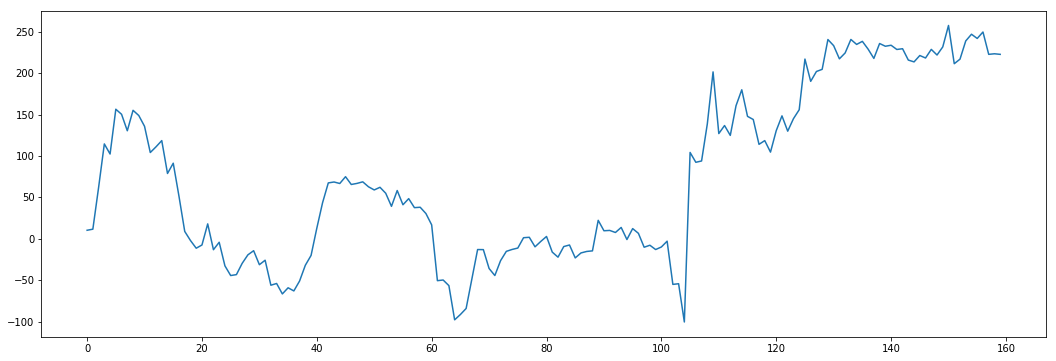

In [93]:
merged_xrp['total_cum_profits'].plot(figsize = (18, 6))

In [92]:
merged_xrp

,time,open,high,low,close,prediction,label_x,label_y,profits,total_cum_profits
0,2018-6-7 0:00,680.1,690.2,654.4,678.5,-577.269459,-10.3,-10.3,10.3,10.3
1,2018-6-8 0:00,678.4,684.4,658.0,668.2,-763.934135,-1.3,-1.3,1.3,11.6
2,2018-6-9 0:00,668.2,679.9,662.0,666.9,-905.718613,-50.3,-50.3,50.3,61.9
3,2018-6-10 0:00,666.9,667.4,610.1,616.6,-1583.653450,-52.7,-52.7,52.7,114.6
4,2018-6-11 0:00,616.3,617.1,551.1,563.9,-1592.382050,12.2,12.2,-12.2,102.4
5,2018-6-12 0:00,563.9,600.0,563.6,576.1,-646.571493,-54.1,-54.1,54.1,156.5
6,2018-6-13 0:00,576.0,576.5,520.1,522.0,-1294.671631,6.1,6.1,-6.1,150.4
7,2018-6-14 0:00,521.9,556.9,503.3,528.1,-630.125761,19.9,19.9,-19.9,130.5
8,2018-6-15 0:00,528.0,569.2,527.4,548.0,-212.739730,-24.7,-24.7,24.7,155.2
9,2018-6-16 0:00,548.2,554.5,518.1,523.3,-430.027866,6.3,6.3,-6.3,148.9


# Build another function to help with optimization

方法一：less preferred method

In [125]:
# This function will be mainly used on local environment for optimization's purpose, not for exporting data to TB.

def merge_and_optimize_dumb_method(asst, df, test_begin):
    # 分析强度信号：
    signal_loc = location
    signal_file = pd.read_csv(signal_loc + "pred_and_true_20181119_{}.csv".format(asst), engine='python')
    del signal_file['Unnamed: 0']
    signal_file.rename(columns={"true": "label"}, inplace = True)
    df_to_merge = df[test_begin:].copy()
    signal_file['time'] = df_to_merge['time'].values
    merged = signal_file.merge(df_to_merge, on = 'time')
#     del merged['label_x']
#     del merged['label_y']
    merged = merged[['time', 'open', 'high', 'low', 'close', 'prediction', 'label_x']]
    merged["profits"] = ""
#     merged.to_csv(location+"{}_ML_result_file_to_test_on_TB.csv".format(asst), index = False)
    for i, prediction in enumerate(merged['prediction']):
        # if we predict the direction correctly:
        if merged['prediction'][i]*merged['label_x'][i] > 0:
            merged['profits'][i] = abs(merged['label_x'][i])
        else:
            merged['profits'][i] = -abs(merged['label_x'][i])
    merged['total_cum_profits'] = merged['profits'].cumsum()
    merged['total_cum_profits'].plot(figsize = (18, 6))
    return merged

方法二：Preferred method

In [136]:
# This function will be mainly used on local environment for optimization's purpose, not for exporting data to TB.

def merge_and_optimize(asst, df, test_begin):
    # 分析强度信号：
    signal_loc = location
    signal_file = pd.read_csv(signal_loc + "pred_and_true_20181119_{}.csv".format(asst), engine='python')
    del signal_file['Unnamed: 0']
    signal_file.rename(columns={"true": "label"}, inplace = True)
    df_to_merge = df[test_begin:].copy()
    signal_file['time'] = df_to_merge['time'].values
    merged = signal_file.merge(df_to_merge, on = 'time')
#     del merged['label_x']
#     del merged['label_y']
    merged = merged[['time', 'open', 'high', 'low', 'close', 'prediction', 'label_x']]
    
    def create_profits(x, y):
        if x * y > 0:
            return abs(y)
        else:
            return -abs(y)
    merged['profits'] = np.vectorize(create_profits)(merged['prediction'], merged['label_x'])
    merged['total_cum_profits'] = merged['profits'].cumsum()
    merged['total_cum_profits'].plot(figsize = (18, 6))
    return_pct = merged['total_cum_profits'].values[-1]/merged['close'].values[0]
    return return_pct

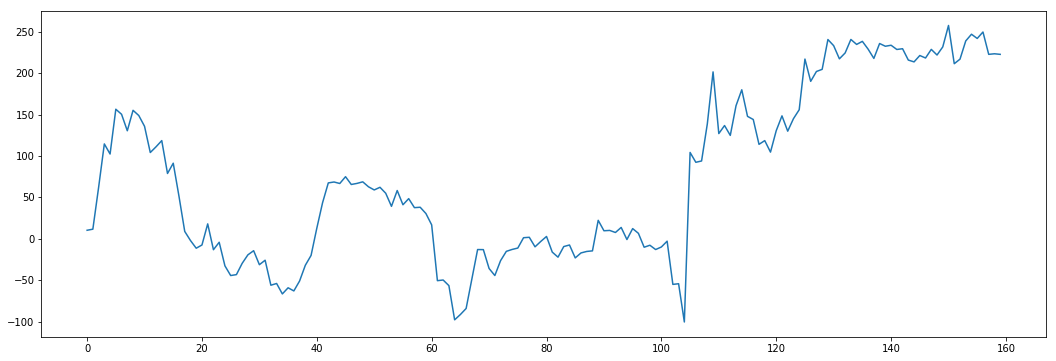

In [137]:
new_xrp = merge_and_optimize('xrp', df_xrp, 195)

In [138]:
new_xrp

0.3283714075165806

In [140]:
# Bets way to solve the problem:

# def create_profits(x, y):
#     if x * y > 0:
#         return abs(y)
#     else:
#         return -abs(y)
    
# merged_xrp['profits'] = np.vectorize(create_profits)(merged_xrp['prediction'], merged_xrp['label_x'])

# All-in-one function of optimization 

In [ ]:
# asst, test_train_split, time_step, rnn_unit, batch_size, train_times, lr
def lstm_all_in_one_optimization():
    # create vars and paras lists:
    paras_to_optimize = {'test_train_split': [],
                     'time_step': [],
                     'rnn_unit': [],
                     'batch_size': [],
                     'train_times':[],
                     'lr':[]}

    optimization_record = {'test_train_split': [],
                         'time_step': [],
                         'rnn_unit': [],
                         'batch_size': [],
                         'train_times':[],
                         'lr':[]}
    
    # first function: create signal files
    lstm_run_through_all(df, asst, test_train_split, time_step, rnn_unit, batch_size, train_times, lr)
    
    # second function: 
    merge_and_optimize(asst, df, test_begin)

In [160]:
# create vars and paras lists:

"""
Here we will use for para in paras_to_optimize:
    ...
"""

# df and df_asst_og are the same
def lstm_all_in_one_optimization(df, df_asst_og, asst, test_train_split, time_step, rnn_unit, batch_size, train_times, lr):
    # Use this code to prevent the kernel from requesting to start again everytime we run the model. 
    tf.reset_default_graph()

    # create func to record paras each time we finish running
    optimization_record = {'test_train_split': [],
                           'time_step': [],
                           'rnn_unit': [],
                           'batch_size': [],
                           'train_times':[],
                           'lr':[],
                           'total_rtrn_pct':[]}
    
    data_len = len(df)
    total_days = data_len
    test_end = total_days
    train_begin = 0
    
    pre_data = df.iloc[:, 4].values  # 取收盘价计算标签
    label = []
    for i in range(1, len(pre_data)):
        label.append(round(pre_data[i] - pre_data[i - 1], 4))

    df.loc[1:, 'label'] = label
    df['label'] = df['label'].shift(-1)
    df.fillna(method='ffill', inplace = True)
    data = df.iloc[:, [1, 2, 3, 5]].values  # 获取特征量及标签，类型为np.ndarray
    # logger.info(data[0:5])

    
    # 参数类别一：
    """
    保持以下参数不变：

    利用过去一天: 2018-11-16 0:00, 来预测下一天：
    time_step = 20
    rnn_unit = 10  # 隐藏层单元数量 ##################调整这个
    input_size = 3  # 输入个数  
    output_size = 1  # 输出个数
    batch_size = 80  # 批量大小  #################调整这个
    train_times = 20  # 训练次数
    lr = 0.001  # 学习率


    test_train_split 参数调优:

    test_train_split   accuracy       信号强度
           0.2           0.55         -55.86
           0.3           0.52         -39.31
           0.4           0.4928        -9.88
           0.5           0.5111       -28.13
           0.6           0.5          -13.87
           0.7           0.4961       -27.13
           0.8           0.4967       -28.58
           0.9           0.5          -9.06

    """

    test_train_split = test_train_split
    time_step = time_step # 20 as default
    split_batch = int(total_days/time_step) 
    time_step_multiple = int(test_train_split*split_batch)
    test_begin = int(test_end - (time_step)*time_step_multiple)
    train_end = test_begin

    # 这里 test_end - test_begin的差一定要是time_step的倍数
#     print ("split_batch: ", split_batch)
#     print ("train_test_split_rate: ", test_train_split)
#     print ("train_begin: ", train_begin)
#     print ("train_end: ", train_end)
#     print ("test_begin: ", test_begin)
#     print ("test_end: ", test_end)
#     print ("time_step: ", time_step)

    # 参数类别二：

    rnn_unit = rnn_unit # 1o as default  # 隐藏层单元数量 ##################调整这个
    input_size = 3  # 输入个数  
    output_size = 1  # 输出个数
    batch_size = batch_size # 80 as default  # 批量大小  #################调整这个
    train_times = train_times # 20 as default  # 训练次数
    lr = lr # 0.001 as default  # 学习率
    # 一般调整隐藏层数量、批量大小及学习率这几个超参数
    # 输入和输出则由特征量和标签确定
    # 本例中，以开盘价、最高价、最低价为特征量，
    # 以收盘价差即涨跌作为标签
    
  

    optimization_record = {'test_train_split': [],
                           'time_step': [],
                           'rnn_unit': [],
                           'batch_size': [],
                           'train_times':[],
                           'lr':[],
                           'total_rtrn_pct':[]}
    
    # Append参数：
    
    optimization_record['test_train_split'].append(test_train_split)
    optimization_record['time_step'].append(time_step)
    optimization_record['rnn_unit'].append(rnn_unit)
    optimization_record['batch_size'].append(batch_size)
    optimization_record['train_times'].append(train_times)
    optimization_record['lr'].append(lr)
    
    
    
    print ("="*60)
    def get_train_data(batch_size, time_step, train_begin, train_end):
        batch_index = []
        data_train = data[train_begin + 1:train_end]
        normalized_train_data = (
            data_train - np.mean(data_train, axis=0)) / np.std(
                data_train, axis=0)
        # logger.info('normalized_train_data.shape: ', normalized_train_data.shape)
        # logger.info(len(normalized_train_data))
        # logger.info(type(normalized_train_data))
        # logger.info(len([0, 2]))
        # logger.info(normalized_train_data[0:20])
        # logger.info(normalized_train_data[0:20, 1])

        train_x, train_y = [], []
        for i in range(len(normalized_train_data) - time_step):
            if i % batch_size == 0:
                batch_index.append(i)

            x = normalized_train_data[i:i + time_step, :3]
            y = normalized_train_data[i:i + time_step, 3, np.newaxis]
            train_x.append(x.tolist())
            train_y.append(y.tolist())

        batch_index.append(len(normalized_train_data) - time_step)
        return batch_index, train_x, train_y


    def get_test_data(time_step, test_begin, test_end):
        data_test = data[test_begin:test_end]
        test_y = data_test[:, 3]
        mean = np.mean(data_test, axis=0)
        std = np.std(data_test, axis=0)
        normalized_test_data = (data_test - mean) / std
        size = (len(normalized_test_data) + time_step - 1) // time_step
        test_x, test_y = [], []
        for i in range(size - 1):
            x = normalized_test_data[i * time_step:(i + 1) * time_step, :3]
            y = normalized_test_data[i * time_step:(i + 1) * time_step, 3]
            test_x.append(x.tolist())
            test_y.extend(y)
            # print('type(y): ', type(y))

        test_x.append((normalized_test_data[(i + 1) * time_step:, :3]).tolist())
        test_y.extend((normalized_test_data[(i + 1) * time_step:, 3]).tolist())
        return mean, std, test_x, test_y


    weights = {
        'in': tf.Variable(tf.random_normal([input_size, rnn_unit])),
        'out': tf.Variable(tf.random_normal([rnn_unit, 1]))
    }
    biases = {
        'in': tf.Variable(tf.constant(0.1, shape=[
            rnn_unit,
        ])),
        'out': tf.Variable(tf.constant(0.1, shape=[
            1,
        ]))
    }


    # 定义神经网络变量
    def lstm(X):
        batch_size = tf.shape(X)[0]
        time_step = tf.shape(X)[1]
        w_in = weights['in']
        b_in = biases['in']
        input_ = tf.reshape(X, [-1, input_size])
        # print('input_.shape: ', input_.shape)
        input_rnn = tf.matmul(input_, w_in) + b_in
        # print('input_rnn.shape: ', input_rnn.shape)
        # tensor转换成3维，作为cell的输入
        input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])
        # print('input_rnn.shape: ', input_rnn.shape)
        cell = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
        init_state = cell.zero_state(batch_size, dtype=tf.float32)
        output_rnn, final_state = tf.nn.dynamic_rnn(
            cell, input_rnn, initial_state=init_state, dtype=tf.float32)
        output = tf.reshape(output_rnn, [-1, rnn_unit])
        w_out = weights['out']
        b_out = biases['out']
        pred = tf.matmul(output, w_out) + b_out
        return pred, final_state


    # 训练模型
    def train_lstm(batch_size, time_step, train_begin, train_end):
        X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
        Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])
        batch_index, train_x, train_y = get_train_data(batch_size, time_step,
                                                       train_begin, train_end)
        with tf.variable_scope('future_lstm'):
            pred, _ = lstm(X)
            loss = tf.reduce_mean(
                tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
            train_operation = tf.train.AdamOptimizer(lr).minimize(loss)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)

            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                for i in range(train_times):
                    for step in range(len(batch_index) - 1):
                        _, loss_ = sess.run(
                            [train_operation, loss],
                            feed_dict={
                                X:
                                train_x[batch_index[step]:batch_index[step + 1]],
                                Y: train_y[batch_index[step]:batch_index[step + 1]]
                            })
                    # print('Number of iterations: {} , loss: {}'.format(i, loss_))
#                     logger.info('Number of iterations: {} , loss: {}'.format(
#                         i, loss_))
    #             print('model saved: ', saver.save(sess, 'model_save1/model.ckpt'))
                print('The train has finished')


    train_lstm(batch_size, time_step, train_begin, train_end)


    def prediction_and_evaluate(time_step):
        X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
    #     print ("X: ", X)  #brad's peek
        mean, std, test_x, test_y = get_test_data(time_step, test_begin, test_end)
        with tf.variable_scope('future_lstm', reuse=True):
            pred, _ = lstm(X)
            saver = tf.train.Saver(tf.global_variables())
            with tf.Session() as sess:
                model_file = tf.train.latest_checkpoint('model_save1')
                saver.restore(sess, model_file)
                test_predict = []
                # brad's peek:
    #             print("test_x")
    #             print (test_x)
                for step in range(len(test_x)):
                    # 一次出time_step个结果，results.shape: (20, 1)
                    results = sess.run(pred, feed_dict={X: [test_x[step]]})
                    # predict = tf.reshape(results, [-1])
                    predict = results.reshape(-1)
                    test_predict.extend(predict)
                # brad's peek:
    #             print (test_predict)
                # 还原真实值
                # brad's peek:
    #             print ("test_y",test_y)
                test_y = np.array(test_y) * std[3] + mean[3]
                test_predict = np.array(test_predict) * std[3] + mean[3]
                true_y = test_y


                # print('test_predict.shape: ', test_predict.shape)
                # print('true_y.shape: ', true_y.shape)
                out = np.c_[test_predict, true_y]
                out_csv = pd.DataFrame(
                    data=out, index=None, columns=['prediction', 'true'])
                right, wrong = 0, 0
                calc_data = map(lambda x, y: tuple((x, y)), test_predict,
                                test_y[:len(test_predict)])
                for data in calc_data:
                    if data[0] * data[1] > 0 or data[0] == data[1]:
                        right += 1
                    else:
                        wrong += 1
                accuracy = right / (right + wrong)
                print("利用过去一天: "+str(df[:test_end].iloc[-1, :].values[0]) + ", 来预测下一天：")
                print (out_csv.iloc[-1, 0])
                logger.info('The accuracy of this prediction: ')
                logger.info(accuracy)
        signal_file = out_csv.copy()
        signal_file.rename(columns={"true": "label"}, inplace = True)
        df_to_merge = df_asst_og[test_begin:].copy()
        signal_file['time'] = df_to_merge['time'].values
        merged = signal_file.merge(df_to_merge, on = 'time')
    #     del merged['label_x']
    #     del merged['label_y']
        merged = merged[['time', 'open', 'high', 'low', 'close', 'prediction', 'label_x']]

        def create_profits(x, y):
            if x * y > 0:
                return abs(y)
            else:
                return -abs(y)
        merged['profits'] = np.vectorize(create_profits)(merged['prediction'], merged['label_x'])
        merged['total_cum_profits'] = merged['profits'].cumsum()
        merged['total_cum_profits'].plot(figsize = (18, 6))
        return_pct = merged['total_cum_profits'].values[-1]/merged['close'].values[0]
        return return_pct

    target_to_optimize = prediction_and_evaluate(time_step)
    optimization_record['total_rtrn_pct'].append(target_to_optimize)
    
    return optimization_record

In [ ]:
# This function will be mainly used on local environment for optimization's purpose, not for exporting data to TB.

def merge_and_optimize(asst, df, test_begin):
    # 分析强度信号：
    signal_loc = location
    signal_file = pd.read_csv(signal_loc + "pred_and_true_20181119_{}.csv".format(asst), engine='python')
    del signal_file['Unnamed: 0']
    signal_file.rename(columns={"true": "label"}, inplace = True)
    df_to_merge = df[test_begin:].copy()
    signal_file['time'] = df_to_merge['time'].values
    merged = signal_file.merge(df_to_merge, on = 'time')
#     del merged['label_x']
#     del merged['label_y']
    merged = merged[['time', 'open', 'high', 'low', 'close', 'prediction', 'label_x']]
    
    def create_profits(x, y):
        if x * y > 0:
            return abs(y)
        else:
            return -abs(y)
    merged['profits'] = np.vectorize(create_profits)(merged['prediction'], merged['label_x'])
    merged['total_cum_profits'] = merged['profits'].cumsum()
    merged['total_cum_profits'].plot(figsize = (18, 6))
    return_pct = merged['total_cum_profits'].values[-1]/merged['close'].values[0]
    return return_pct

In [170]:
paras_to_optimize = {'test_train_split': [0.2, 0.3],
                     'time_step': [20, 30],
                     'rnn_unit': [],
                     'batch_size': [],
                     'train_times':[],
                     'lr':[],
                     'total_rtrn_pct':[]}

In [173]:
results_list = []

The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
0.9287023544311523
2018-11-19 18:25:38,522 INFO in line 290: The accuracy of this prediction: 
2018-11-19 18:25:38,550 INFO in line 291: 0.5333333333333333
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
0.7761862277984619
2018-11-19 18:25:50,145 INFO in line 290: The accuracy of this prediction: 
2018-11-19 18:25:50,164 INFO in line 291: 0.55
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
-0.23783421516418457
2018-11-19 18:25:59,815 INFO in line 290: The accuracy of this prediction: 
2018-11-19 18:25:59,826 INFO in line 291: 0.55
The train has finished
INFO:tensorflow:Restoring parameters from model_save1\model.ckpt
利用过去一天: 2018-11-13 0:00, 来预测下一天：
1.9541393518447876
2018-11-19 18:26:09,505 INFO in line 290: The accuracy 

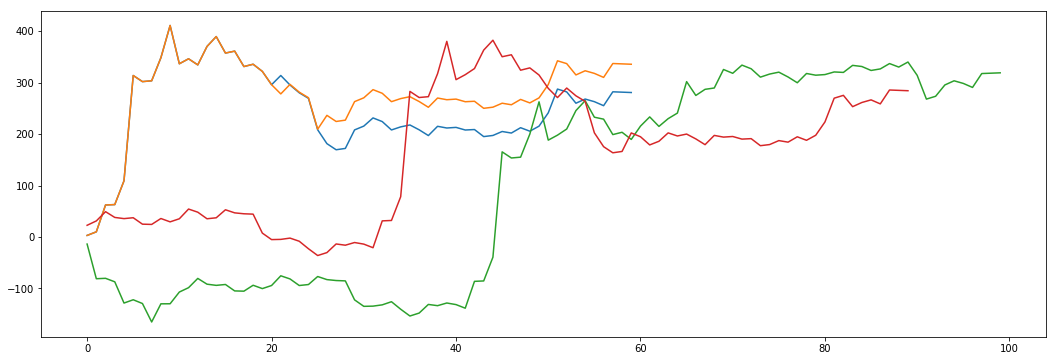

In [177]:
for tts in paras_to_optimize['test_train_split']:
    for ts in paras_to_optimize['time_step']:
#         results = lstm_all_in_one_optimization(df_xrp, df_xrp, 'xrp', 
#                                      test_train_split = tts, 
#                                      time_step = ts, 
#                                      rnn_unit = 10, 
#                                      batch_size = 80, 
#                                      train_times = 20, 
#                                      lr = 0.001)

        lstm_all_in_one_optimization(df_xrp, df_xrp, 'xrp', 
                                     test_train_split = tts, 
                                     time_step = ts, 
                                     rnn_unit = 10, 
                                     batch_size = 80, 
                                     train_times = 20, 
                                     lr = 0.001)
# results_list.append(results)

In [175]:
results_list

[{'test_train_split': [0.3],
  'time_step': [30],
  'rnn_unit': [10],
  'batch_size': [80],
  'train_times': [20],
  'lr': [0.001],
  'total_rtrn_pct': [0.9723171565276831]}]

In [154]:
merged_xrp

,time,open,high,low,close,prediction,label_x,label_y,profits,total_cum_profits
0,2018-6-7 0:00,680.1,690.2,654.4,678.5,-577.269459,-10.3,-10.3,10.3,10.3
1,2018-6-8 0:00,678.4,684.4,658.0,668.2,-763.934135,-1.3,-1.3,1.3,11.6
2,2018-6-9 0:00,668.2,679.9,662.0,666.9,-905.718613,-50.3,-50.3,50.3,61.9
3,2018-6-10 0:00,666.9,667.4,610.1,616.6,-1583.653450,-52.7,-52.7,52.7,114.6
4,2018-6-11 0:00,616.3,617.1,551.1,563.9,-1592.382050,12.2,12.2,-12.2,102.4
5,2018-6-12 0:00,563.9,600.0,563.6,576.1,-646.571493,-54.1,-54.1,54.1,156.5
6,2018-6-13 0:00,576.0,576.5,520.1,522.0,-1294.671631,6.1,6.1,-6.1,150.4
7,2018-6-14 0:00,521.9,556.9,503.3,528.1,-630.125761,19.9,19.9,-19.9,130.5
8,2018-6-15 0:00,528.0,569.2,527.4,548.0,-212.739730,-24.7,-24.7,24.7,155.2
9,2018-6-16 0:00,548.2,554.5,518.1,523.3,-430.027866,6.3,6.3,-6.3,148.9


In [151]:
optimization_record['test_train_split'].append(4)

In [146]:
optimization_record.update({'test_train_split':0.5})

In [147]:
optimization_record

{'test_train_split': 0.5}